In [1]:
from pathlib import Path

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyprojroot
import seaborn as sns

import searchnets

In [2]:
def cm_to_inches(cm):
    return cm / 2.54

In [3]:
mpl.style.use(['seaborn-darkgrid', 'seaborn-paper'])

paths

In [4]:
SOURCE_DATA_ROOT = pyprojroot.here('results/searchstims/source_data/')

FIGURES_ROOT = pyprojroot.here('docs/paper/figures/experiment-1/searchstims-3stims-multiple-source-datasets')

constants

In [5]:
LEARNING_RATE = 1e-3

NET_NAMES = [
    'alexnet',
    'VGG16',
]

METHODS = [
    'initialize',
    'transfer'
]

MODES = [
    'classify',
]

In [6]:
sns.set_palette("Set2")

## load / tidy source data

In [7]:
df_all = []

for source_data_dir, pretrained in zip(
    ['3stims', '3stims_random_weights_transfer', '3stims_SIN', '3stims_Clipart'],
    ['ImageNet', 'random weights', 'Stylized ImageNet', 'DomainNet, Clipart domain']
):

    df = pd.read_csv(SOURCE_DATA_ROOT / source_data_dir / 'all.csv')

    df = df[df.net_name.isin(NET_NAMES)]

    if source_data_dir == '3stims':
        df['dataset'] = np.nan
        df.loc[df['method'] == 'transfer', 'dataset'] = pretrained
        df.loc[df['method'] == 'initialize', 'dataset'] = 'Searchstims'
    else:
        df['dataset'] = pretrained

    df['method, dataset'] = df['method'] + ', ' + df['dataset']

    df_all.append(df)

df_all = pd.concat(df_all)

df_all = df_all[df_all.target_condition == 'both']

# map set sizes to consecutive integers
set_size_uniq = df_all.set_size.unique()
set_size_map = dict(zip(set_size_uniq, range(len(set_size_uniq))))
df_all['set_size_int'] = df_all.set_size.map(set_size_map)

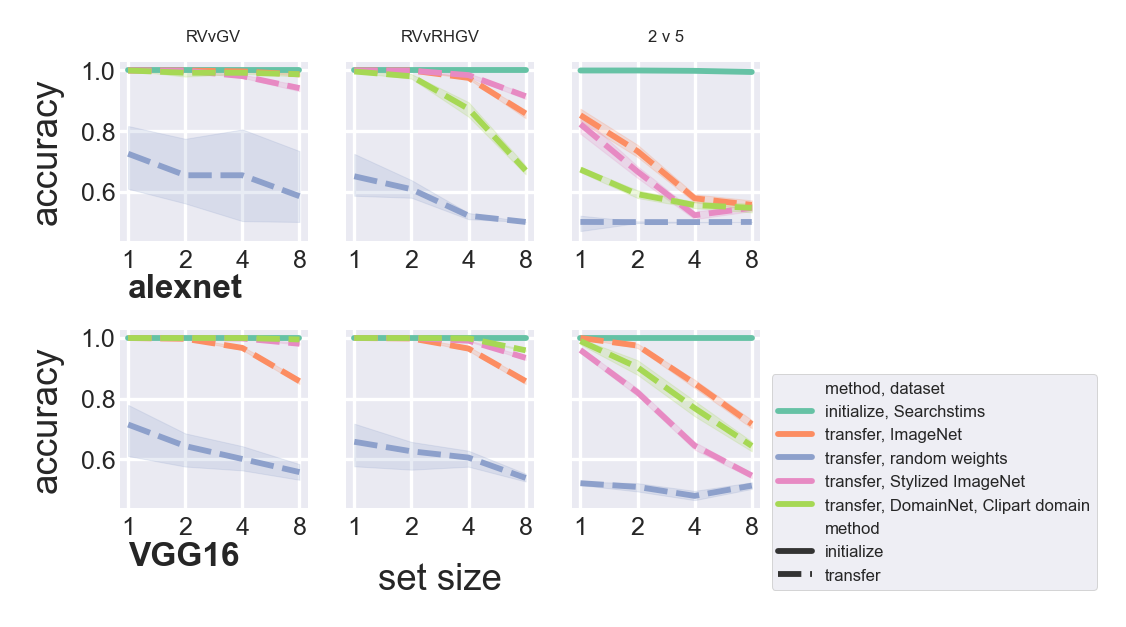

In [8]:
if '3stims' in str(FIGURES_ROOT):
    FIGSIZE = tuple(cm_to_inches(size) for size in (7, 5))
elif '10stims' in str(FIGURES_ROOT):
    FIGSIZE = tuple(cm_to_inches(size) for size in (17.4, 10))

DPI = 300

FIG_ROWS = df_all.net_name.unique()
FIG_COLUMNS = df_all.stimulus.unique()

n_rows = len(FIG_ROWS)
n_cols = len(FIG_COLUMNS)
fig, ax_arr = plt.subplots(n_rows, n_cols, sharey=True, figsize=FIGSIZE, dpi=DPI)
fig.subplots_adjust(hspace=0.5)

LABELSIZE = 6
XTICKPAD = 2
YTICKPAD = 1

for ax_ in ax_arr.ravel():
    ax_.xaxis.set_tick_params(pad=XTICKPAD, labelsize=LABELSIZE)
    ax_.yaxis.set_tick_params(pad=YTICKPAD, labelsize=LABELSIZE)
    

STIM_FONTSIZE = 4

add_legend = False

for row, net_name in enumerate(FIG_ROWS):
    df_this_net = df_all[df_all['net_name'] == net_name]

    for col, stim_name in enumerate(FIG_COLUMNS):
        df_this_net_this_stim = df_this_net[df_this_net.stimulus == stim_name]

        ax = ax_arr[row, col]
        ax.set_axisbelow(True)  # so grid is behind

        if row == 0 and col == 0:
            legend = True
        else:
            legend = False

        sns.lineplot(
            x='set_size_int',
            y='accuracy',
            data=df_this_net_this_stim, 
            hue='method, dataset', 
            style='method',
            ax=ax,
            legend=legend
        )
        ax.set_ylabel('')
        ax.set_xlabel('')
        ax.set_xticks(range(len(set_size_uniq)))
        ax.set_xticklabels(set_size_uniq)

        if row == 0:
            title = stim_name.replace('_',' ')
            ax.set_title(title, 
                         fontsize=STIM_FONTSIZE,
                         pad=5)  # pad so we can put image over title without it showing
        if col == 0:
            ax.set_ylabel('accuracy')
            net_name_for_fig = net_name.replace('_', ' ')
            ax.text(0, 0.25, net_name_for_fig, fontweight='bold', fontsize=8)

# add a big axis, hide frame
big_ax = fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axis
big_ax.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
big_ax.grid(False)

handles, labels = ax_arr[0, 0].get_legend_handles_labels()
ax_arr[0, 0].get_legend().remove()

LEGEND_FONTSIZE = 4

if '3stims' in str(FIGURES_ROOT):
    BBOX_TO_ANCHOR = (1.525, 0.3)
elif '10stims' in str(FIGURES_ROOT):
    BBOX_TO_ANCHOR = (0.005, 0.55, 0.4, .075)

big_ax.legend(handles,
              labels, 
              bbox_to_anchor=BBOX_TO_ANCHOR,
              frameon=True,
              borderaxespad=0., 
              fontsize=LEGEND_FONTSIZE
             );

big_ax.set_xlabel("set size", labelpad=0.1);

for ext in ('svg', 'png'):
    fig_path = FIGURES_ROOT.joinpath(
        f'acc-v-set-size/acc-v-set-size.{ext}'
    )
    plt.savefig(fig_path)